In [1]:

import gc
import os

import numpy as np
import pandas as pd
import networkx as nx

from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

DATA_PATH = '../../data/'

gc.collect()

0


## Goal

The purpose of this notebook is to compare methods for rating player skill over the course of a season. In many types of sports, one data problem is that players are playing against each other, and so basic regression independence assumptions are violated. For example, there are only a finite number of rebounds available during a basketball game, and one player or team grabbing a rebound is at the other teams expense. Therefore Player A's data point is not independent of Player B's data point. This pairwise data naturally lends itself to an zero-sum elo model or network model instead of a regression model. A team like Gonzaga is notable because they put up gaudy numbers against weak competition, but are recently 1-11 vs high rated teams (seeds 1-3) in the tournament. Even if some of that performance is simply bad variance, it is obvious that a model would do better predicting Gonzaga's future success if it is aware of the strength of Gonzaga's past competition. In other words, statistical averages can't be compared without taking into account opponent. 

Another potential problem with regression is the sheer number of observations in order to calculate a player rating at any given time. I will expand on both of these problems below.


In [2]:

# get opponent team id
def get_opponent_team_id(data):
    
    opps = data.copy()[['game_id','team_id']].drop_duplicates().reset_index(drop=True)
    opps['team_AorB'] = opps.groupby(['game_id'])['team_id'].rank('dense').astype(int).map({
        1:'A',
        2:'B'
    })
    opps = opps.pivot(index='game_id', columns=['team_AorB'], values='team_id').reset_index()
    opps.columns=['game_id','team_id','opp_id']
    opps2 = opps.copy()
    opps2.columns=['game_id','opp_id','team_id']
    opps = pd.concat([opps, opps2], axis=0).dropna().reset_index(drop=True)
    opps['team_id'] = opps['team_id'].astype(int)
    opps['opp_id'] = opps['opp_id'].astype(int)
    
    return opps


In [3]:


def get_possessions(pbox_data):
    
    opponent_ids = get_opponent_team_id(pbox_data.copy())
    ## estimate number of possessions from box score 
    poss = pbox_data.groupby(['game_id','team_id'])[['fga','to','fta','oreb']].sum().reset_index()
    ## commonly used possession estimate formula
    ## (FGA – OR) + TO + (0.44 * FTA)
    poss['tm_poss'] = (poss['fga'].copy()-poss['oreb'].copy())+poss['to'].copy()+(0.44*poss['fta'].copy())
    poss = poss.drop(columns=['fga','to','fta','oreb'])

    possession_key = opponent_ids.copy().merge(poss, how='left', on=['game_id','team_id'])
    poss = poss.rename(columns={'team_id':'opp_id','tm_poss':'opp_poss'})
    possession_key = possession_key.copy().merge(poss, how='left', on=['game_id','opp_id'])
    possession_key['game_possessions'] = possession_key[['tm_poss','opp_poss']].copy().mean(axis=1)
    possession_key = possession_key.drop(columns=['tm_poss','opp_poss','opp_id'])

    return possession_key.sort_values(by='game_id').reset_index(drop=True)

def add_player_boxscore_features(data):
    
    #pbox
    data['fgm'] = data['fg'].apply(lambda x: x.split('-')[0])
    data['fga'] = data['fg'].apply(lambda x: x.split('-')[-1])
    data['fg3m'] = data['fg3'].apply(lambda x: x.split('-')[0])
    data['fg3a'] = data['fg3'].apply(lambda x: x.split('-')[-1])
    data['ftm'] = data['ft'].apply(lambda x: x.split('-')[0])
    data['fta'] = data['ft'].apply(lambda x: x.split('-')[-1])

    data['fgm']= data['fgm'].replace('',0)
    data['fgm'] = data['fgm'].astype(int)
    data['fga']= data['fga'].replace('',0)
    data['fga'] = data['fga'].astype(int)
    data['ftm']= data['ftm'].replace('',0)
    data['ftm'] = data['ftm'].astype(int)
    data['fta']= data['fta'].replace('',0)
    data['fta'] = data['fta'].astype(int)
    
    data['oreb']= data['oreb'].replace('',0)
    data['oreb'] = data['oreb'].astype(int)
    data['dreb']= data['dreb'].replace('',0)
    data['dreb'] = data['dreb'].astype(int)
    data['reb']= data['reb'].replace('',0)
    data['reb'] = data['reb'].astype(int)

    data['fg3m']= data['fg3m'].replace('',0)
    data['fg3m'] = data['fg3m'].astype(int)
    data['fg3a']= data['fg3a'].replace('',0)
    data['fg3a'] = data['fg3a'].astype(int)

    data['fg2m'] = data['fgm'].copy()-data['fg3m'].copy()
    data['fg2a'] = data['fga'].copy()-data['fg3a'].copy()
    
    possess = get_possessions(data.copy())
    data = data.merge(possess, how='left', on=['game_id','team_id'])

    data['fg%'] = (data['fgm'].copy()/data['fga'].copy()).fillna(0)
    data['fg2%'] = (data['fg2m'].copy()/data['fg2a'].copy()).fillna(0)
    data['fg3%'] = (data['fg3m'].copy()/data['fg3a'].copy()).fillna(0)

    data['eFG%'] = ((data['fgm'].copy()+(data['fg3m'].copy()*0.5))/data['fga'].copy()).fillna(0)
    data['TS%'] = ((data['pts'].copy())/(2*(data['fga'].copy()+(0.44*data['fta'].copy())))).fillna(0)
    # pbox[['fg','fg3m','fga']].dtypes
    data['pts_pm'] = data['pts'].copy()/data['min'].copy()
    data['reb_pm'] = data['reb'].copy()/data['min'].copy()
    data['ast_pm'] = data['ast'].copy()/data['min'].copy()
    data['stl_pm'] = data['stl'].copy()/data['min'].copy()
    data['blk_pm'] = data['blk'].copy()/data['min'].copy()
    data['to_pm'] = data['to'].copy()/data['min'].copy()
    data['pf_pm'] = data['pf'].copy()/data['min'].copy()
    
    ## could be improved with OT markers
    ## percentage of estimated possessions player took part of
    data['player_possessions'] = data['game_possessions'].copy()*(data['min'].copy()/(40*2)) # times 2 because game possessions = 
    
    data['pts_pp'] = data['pts'].copy()/data['player_possessions'].copy()
    data['reb_pp'] = data['reb'].copy()/data['player_possessions'].copy()
    data['ast_pp'] = data['ast'].copy()/data['player_possessions'].copy()
    data['stl_pp'] = data['stl'].copy()/data['player_possessions'].copy()
    data['blk_pp'] = data['blk'].copy()/data['player_possessions'].copy()
    data['to_pp'] = data['to'].copy()/data['player_possessions'].copy()
    data['pf_pp'] = data['pf'].copy()/data['player_possessions'].copy()
    
    return data


def clean_player_boxscores(data):
    for stat_col in ['min','pts','oreb','dreb','reb','ast','stl','blk','to','pf']:
        data[stat_col] = data[stat_col].replace('--',0)
        data[stat_col] = data[stat_col].astype(int)

    return data


def load_player_boxscore_season(year):
    return add_player_boxscore_features(\
            clean_player_boxscores(\
            pd.read_csv(os.path.join(DATA_PATH, f'ESPN/player_boxscores/{year}.csv'))))


pbox = load_player_boxscore_season(2022)
opponent_ids = get_opponent_team_id(pbox.copy())


/var/folders/6j/0sqk1ykn5f10xfsflg6djktr0000gn/T/ipykernel_67646/949352743.py:100: DtypeWarning: Columns (6,7,8,9,10,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  pbox = load_player_boxscore_season(2022)



#### Most Basic Rating System: Player Averages

First, I'll focus on player points scored, since that is the objective of basketball. Other stats are useful in describing the game, but points are the most important. The most natural way to figure out who is the best at scoring points is to sum up each player's points scored over a season.

It also helps to standardize points by minute, so that players aren't penalized if they aren't playing. A common alternative form of standardization is dividing by possessions. That is also viable, and we will use that in some situations as well. 

I also remove observations where a player plays less than five minutes to avoid crazy points per minute outliers. Notable players generally play more than five minutes anyway as they are helping the team.


In [4]:

## minimum sample size
pbox = pbox.loc[pbox['min']>=5].reset_index(drop=True)

## minimum sample for season
minute_thresh = pbox.groupby(['athlete_id'])['min'].sum().sort_values(ascending=False).reset_index()
keep = list(minute_thresh.loc[minute_thresh['min']>=120]['athlete_id'].values) # three full games worth of time
pbox = pbox.loc[pbox['athlete_id'].isin(keep)].reset_index(drop=True)


## create name mapping
players_id2name = pbox.copy().drop_duplicates(subset=['athlete_id'])[['athlete_id','athlete_display_name']].set_index('athlete_id').to_dict()['athlete_display_name']
players_name2id = {v:k for k,v in players_id2name.items()}

players_id2team = pbox.copy().drop_duplicates(subset=['athlete_id'],keep='last')[['athlete_id','team_short_display_name']].set_index('athlete_id').to_dict()['team_short_display_name']

teams_id2name = pbox.copy().drop_duplicates(subset=['team_id'])[['team_id','team_short_display_name']].set_index('team_id').to_dict()['team_short_display_name']
teams_name2id = {v:k for k,v in teams_id2name.items()}

## average points per minute
pts_pm = pbox.groupby(['athlete_id'])['pts_pm'].mean().sort_values(ascending=False).reset_index()
pts_pm['player_name'] = pts_pm['athlete_id'].map(players_id2name)
pts_pm['player_team'] = pts_pm['athlete_id'].map(players_id2team)

pts_pm.head(10)



,athlete_id,pts_pm,player_name,player_team
0,4594327,0.777265,Keegan Murray,Iowa
1,4396745,0.755613,Darius McGhee,Liberty
2,4600663,0.750542,Zach Edey,Purdue
3,4433192,0.713129,Tari Eason,LSU
4,4070686,0.711855,Peter Kiss,Bryant
5,4396933,0.709516,D.J. Burns Jr.,Winthrop
6,4396597,0.698410,Ryan Davis,Vermont
7,4432828,0.682895,Kofi Cockburn,Illinois
8,4397433,0.681612,Bryce Hamilton,UNLV
9,4896378,0.667663,Jao Ituka,Marist



Only a few of these names are in consideration for player of the year or are on good teams. A couple of flaws are becoming apparent. Two components, specifically, can lead to high points per minute but are perhaps not reflective of skill. Take Peter Kiss and the Bryant team for example. They play at a torrid pace, 4th in the nation. A quick pace allows them to score a lot of points, but also inflates their opponents score (as every time they are done with their quick possession, the opponent gets it). They also have the 346th/358th opponent difficulty (both numbers per Kenpom). Peter Kiss's numbers are likely very much inflated by opponents and pace. If we are looking for predictive skill rankings, we will want to adjust for these factors. 



#### Less Basic Rating System: Regression

In order to adjust for opponent, we can one hot encode both players and their team opponents, and run a regression on the very wide and long dataframe. The coefficients of the regression will rate a player's offense and also the opponent's defense.



In [5]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder

reg_data = pbox.copy()[['game_id','team_id','athlete_id','pts_pm']]
reg_data = reg_data.merge(opponent_ids.copy(),how='left', on=['game_id','team_id'])
reg_data = reg_data.dropna().reset_index(drop=True)
reg_data['opp_id'] = reg_data['opp_id'].astype(int)



In [6]:

## one hot encode players and their opponents
opp_ohe = OneHotEncoder()
player_ohe = OneHotEncoder()
reg_data = reg_data.sample(frac=1).reset_index(drop=True)
player_X = player_ohe.fit_transform(reg_data.athlete_id.values.reshape(-1,1)).toarray()

opp_X = opp_ohe.fit_transform(reg_data.opp_id.values.reshape(-1,1)).toarray()
print("X shapes", player_X.shape, opp_X.shape)



X shapes (93080, 3628) (93080, 658)


In [7]:

## Fit model
X = np.concatenate([player_X, opp_X], axis=1)
y = reg_data.copy().pts_pm.values.reshape(-1,1)

model = Ridge()
model.fit(X, y)

num_players = len(player_ohe.categories_[0])
num_teams = len(opp_ohe.categories_[0])
player_coef = pd.DataFrame.from_dict({
    'player_id':player_ohe.categories_[0],
    'player_points_coef':model.coef_[0][:num_players].reshape(-1)
})
team_coef = pd.DataFrame.from_dict({
    'team_id':opp_ohe.categories_[0],
    'team_points_coef':model.coef_[0][-num_teams:].reshape(-1)
})


In [8]:

## extract player rankings
player_coef = player_coef.sort_values(by='player_points_coef',ascending=False)
player_coef['player_name'] = player_coef['player_id'].map(players_id2name)
player_coef['player_team'] = player_coef['player_id'].map(players_id2team)
player_coef.head(20)


,player_id,player_points_coef,player_name,player_team
2307,4594327,0.468628,Keegan Murray,Iowa
2335,4600663,0.446600,Zach Edey,Purdue
1699,4433192,0.407418,Tari Eason,LSU
700,4396745,0.391657,Darius McGhee,Liberty
1563,4432828,0.382150,Kofi Cockburn,Illinois
142,4070686,0.367452,Peter Kiss,Bryant
930,4397433,0.362852,Bryce Hamilton,UNLV
730,4396933,0.360566,D.J. Burns Jr.,Winthrop
669,4396597,0.347002,Ryan Davis,Vermont
1283,4431695,0.340657,Drew Timme,Gonzaga


In [9]:

## Extract defense rankings
team_coef = team_coef.sort_values(by='team_points_coef')
team_coef['team_name'] = team_coef['team_id'].map(teams_id2name)
team_coef.head(10)


,team_id,team_points_coef,team_name
137,249,-0.148274,North Texas
136,248,-0.145808,Houston
9,21,-0.142232,San Diego State
479,2641,-0.141260,Texas Tech
122,222,-0.139540,Villanova
472,2633,-0.138407,Tennessee
59,99,-0.138050,LSU
461,2608,-0.136566,Saint Mary's
41,66,-0.133863,Iowa State
146,258,-0.129863,Virginia



#### Regression evaluation

The regression method is an upgrade. It was able to knock players on bad teams, like Peter Kiss and Darius McGhee, down a couple of spots. As a nice bonus, it was able to identify defensive teams and slow teams. San Diego St. and Texas Tech for example are the top 2 KenPom rated defenses. North Texas has a good defense and is the slowest team out of 358!

It's not perfect however. Peter Kiss doesn't seem to be very penalized for having extreme benefits in who he plays and his team's pace. Additionally, it takes about 9 seconds to run a simple regression. While 9 seconds isn't much on its own, that quickly compounds if players are used instead of teams as opponents (about 40% more covariates). Computation time would also compound if using more than a year of history, and past years can be very informative for players who only have at maximum 4 years. Lastly, in order to predict future games, many stats at many time points would be desirable. If, for example, 20 stats were needed after every day with games over a few years, 20 stats * ~100 days * 8 seasons would increase the computation time 16,000 times to about 40 hours. 


In [10]:
# %%timeit

# X = np.concatenate([player_X, opp_X], axis=1)
# y = reg_data.copy().pts_pm.values.reshape(-1,1)

# model = Ridge()
# model.fit(X, y)



#### Pagerank method

Network methods naturally lend themselves to this sort of data because each data point should affect the ranking of both teams simultaneously. At first, for each game, I'll try creating a directed edge from players with less points per minute to players on the opposing team with more points per minute. In this way, players with the most points per minute will have many inbound links, analogous to a popular page on the internet. 


In [199]:

def create_graph(graph_data):
    
    
    p2p1 = graph_data.copy().loc[graph_data['p2p1']==1].reset_index(drop=True)
    p1p2 = graph_data.copy().loc[graph_data['p2p1']==0].reset_index(drop=True)

    nodes = list(set(list(graph_data.player_1_id.unique())+list(graph_data.player_2_id.unique())))
#     print(f"There are {len(nodes)} players")

    p2p1 = p2p1[['player_2_id','player_1_id']]
    p1p2 = p1p2[['player_1_id','player_2_id']]
    p2p1.columns=['sender','receiver']
    p1p2.columns=['sender','receiver']

    edges = pd.concat([p2p1, p1p2], axis=0).reset_index(drop=True)
    edges = [tuple([e[0], e[1]]) for e in edges.values]
    
#     print(f"There are {np.round(len(edges)/len(nodes))} observations per player, on average")
    
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    return G


def get_pagerank(net, stat, min_threshold=5):
    
    net = net.copy().loc[net['min']>=min_threshold].reset_index(drop=True)
    
    net = net[['game_id','team_id','athlete_id',stat,'min']]
    net['team_order'] = net.copy().groupby(['game_id'])['team_id'].rank('dense').astype(int).map({
        1:'A',
        2:'B'
    })
    net['player_order'] = net.copy().groupby(['game_id','team_id'])['min'].rank('dense').astype(int)
    # re rank after cutoff
    net = net.sort_values(by=['game_id','team_id','min'], ascending=[True, True, False])
    net['player_order'] = net.copy().groupby(['game_id','team_id'])['min'].rank('first',ascending=False).astype(int)
    net = net.loc[net['player_order']<=8].reset_index(drop=True)
    net['player_team_id'] = net['team_order'].astype(str) + '-' +net['player_order'].astype(str)
    
    net = net.pivot(index='game_id', columns='player_team_id', values=['athlete_id',stat]).reset_index()
    
    net_data = []
    for player_1 in [f'A-{i}' for i in range(1, 9)]:
        for player_2 in [f'B-{i}' for i in range(1, 9)]:
            matchup = pd.concat([net['athlete_id'][[player_1, player_2]], net[stat][[player_1, player_2]]], axis=1)
            matchup.columns=['player_1_id','player_2_id','player_1_pts','player_2_pts']
            net_data.append(matchup)

    net_data = pd.concat(net_data)
    
    net_data = net_data.dropna().reset_index(drop=True)
    net_data['player_1_id'] = net_data['player_1_id'].astype(int)
    net_data['player_2_id'] = net_data['player_2_id'].astype(int)

    # if ppm equal, no blood (no link)
    net_data['to_drop'] = np.where(net_data['player_1_pts']==net_data['player_2_pts'], 1, 0)
    net_data = net_data.loc[net_data['to_drop']==0].reset_index(drop=True)
    net_data = net_data.drop(columns=['to_drop'])
    net_data['p2p1'] = np.where(net_data['player_1_pts']>net_data['player_2_pts'],1,0)
    
    graph = create_graph(net_data.copy())
    
    prnk = nx.pagerank(graph)
    prnk = pd.Series(prnk).reset_index()
    
    prnk.columns=['player_id', f'{stat}_prnk']

    return prnk.sort_values(by=[f'{stat}_prnk'], ascending=False).reset_index(drop=True)




In [200]:

# %%timeit

# stat_ = 'pts_pm'
# tmp_prnk = get_pagerank(pbox, stat_)



In [201]:

stat_ = 'pts_pm'
tmp_prnk = get_pagerank(pbox, stat_)
tmp_prnk = tmp_prnk.sort_values(by='pts_pm_prnk',ascending=False)
tmp_prnk['player_name'] = tmp_prnk['player_id'].map(players_id2name)
tmp_prnk['player_team'] = tmp_prnk['player_id'].map(players_id2team)
tmp_prnk.head(20)



,player_id,pts_pm_prnk,player_name,player_team
0,4432639,0.000903,Jabari Smith,Auburn
1,4278435,0.000897,JD Notae,Arkansas
2,4594327,0.000832,Keegan Murray,Iowa
3,4432573,0.000829,Paolo Banchero,Duke
4,4600663,0.000817,Zach Edey,Purdue
5,4432821,0.000814,E.J. Liddell,Ohio State
6,4433192,0.000802,Tari Eason,LSU
7,4432828,0.000798,Kofi Cockburn,Illinois
8,4432180,0.000793,Hunter Dickinson,Michigan
9,4431785,0.000790,Scotty Pippen Jr.,Vanderbilt



### Pagerank Evaluation

Pagerank replaces players on bad teams, like Peter Kiss and Darius McGhee, with future NBA lottery picks, Jabari Smith and Paolo Banchero. It's also able to handle other players as defenders rather than just teams which incorporates more information. For example, if a star player gets injured, or a lineup changes, the profile of a team can change dramatically. Network data going will only be reflective of the team with those personnel changes going forward. Also, the pagerank method dramatically cuts down the computation time by 1/7th. These computation gains only get more dramatic as things are scaled up. 

However, pagerank is not without faults. JD Notae and Jabari Smith are being rewarded for their team's good defense. This can be seen as a positive, because the players are somewhat responsible for their team's defense and this tends to push better players to the top of the rankings. On the other hand, if Keegan Murray or E.J. Liddell played for Arkansas, they would most likely see a better pagerank score because they would have teammates that are better defenders. It would be nice to isolate players from the environment they play in as best we can. Additionally, in its current state, pagerank is not considering edge magnitude. A 97-60 scoreline will have mostly the same edges as a 70-60 scoreline. Pagerank can be further improved with weighted edges.


For now, I'll stick with the eye test, but will move on to empirical tests in other notebooks.



### Pagerank Improvements

In order to help interpretability, and isolate a player's offensive points for the environment he plays in, we can come up with separate graphs and rankings that control for pace and defense.

*Team Pace* - Both teams in a game have about the same amount of number of possessions, since ending one team's possession automatically gives the ball to the other team. However, if a team is forcing quick possessions, there will be more possessions than usual in a game. These are known as high pace teams. A strong candidate to evaluate a team's pace is an undirected weighted graph that is weighted by number of shared possessions in the game.

*Team Defense* - Team defense is slightly harder because the points per minute method used above automatically weights offense as well. Instead, for team defense, we can use edges weighted by points per possession (to control for pace). This will assume an 8 player rotation and be undirected however links from defenses to opposing players will be normalized by 1/8 to keep them on the same scale. Efficient points per possession scorers will have high page ranks and good defenses will have small pagerank.   



In [193]:

# need to create possession estimates
def create_pace_net(data):
    
    opp_data = get_opponent_team_id(data.copy())
    game_possessions = get_possessions(data.copy())
    net_data = pd.merge(opp_data.copy(), game_possessions.copy(), how='left', on=['game_id','team_id'])
    net_data = net_data.drop_duplicates(subset=['game_id']).reset_index(drop=True)
    net_data['team_id'] = net_data['team_id'].astype(int)
    net_data['opp_id'] = net_data['opp_id'].astype(int)
    
    mms = MinMaxScaler()
    net_data['game_possessions'] = mms.fit_transform(net_data['game_possessions'].values.reshape(-1,1))
    
    nodes = list(set(net_data['team_id'].unique()).union(set(net_data.opp_id.unique())))
    edges = [tuple([int(e[0]),int(e[1]),e[2]]) for e in net_data[['team_id','opp_id','game_possessions']].values.copy()]

    pace_net = nx.MultiGraph()
    pace_net.add_nodes_from(nodes)
    pace_net.add_weighted_edges_from(edges)
    pace_ranks = pd.Series(nx.pagerank(pace_net)).reset_index()
    pace_ranks.columns=['team_id','prank']
    pace_ranks['team_name'] = pace_ranks['team_id'].map(teams_id2name)
    
    degrees = pd.DataFrame.from_dict(pace_net.degree())
    degrees.columns=['team_id','degree']
    pace_ranks = pace_ranks.copy().merge(degrees, how='left', on='team_id')
    pace_ranks['pace_rating'] = 100000* (pace_ranks['prank'].copy()/pace_ranks['degree'].copy())
    pace_ranks = pace_ranks.sort_values(by='pace_rating', ascending=False)
    
    pace_ranks = pace_ranks.loc[pace_ranks['degree']>25].drop(columns=['prank','degree'])  # minimum 25 games played (some DII teams show up otherwise)
    
    pace_ranks['pace_rank'] =pace_ranks['pace_rating'].rank(method='dense', ascending=False)
    return pace_ranks.reset_index(drop=True)

pace_series = create_pace_net(pbox.copy())

                                              

In [194]:
print("Top 10 Fastest Teams")
pace_series.head(10) 

Top 10 Fastest Teams


,team_id,team_name,pace_rating,pace_rank
0,2377,McNeese,11.151536,1.0
1,2569,SC State,11.084705,2.0
2,2803,Bryant,11.048308,3.0
3,47,Howard,11.042953,4.0
4,2443,New Orleans,11.028316,5.0
5,2198,E Kentucky,10.705045,6.0
6,3101,Dixie State,10.672954,7.0
7,189,Bowling Green,10.658217,8.0
8,292,UT Rio Grande,10.577935,9.0
9,2110,C Arkansas,10.572552,10.0



### Pace Net

These names check out as high pace teams per KenPom. There are some decent discrepancies (~30 ranks) that warrent further investigation


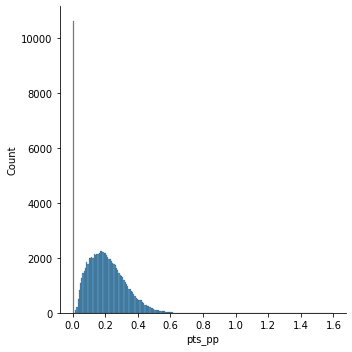

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt

# worth noting there are a lot of players that don't score during their time in the game
# I assume an 8 man rotation (8 players play substantial time) for every team, but some teams use 7 which would inflate
# defensive numbers
sns.displot(pbox['pts_pp'])
plt.show()


In [197]:


def get_defense_ranks(net, stat='pts_pp',min_threshold=5):
    
    net = net.copy().loc[net['min']>=min_threshold].reset_index(drop=True)
    net = net[['game_id','team_id','athlete_id',stat,'min']]
    net['team_order'] = net.copy().groupby(['game_id'])['team_id'].rank('dense').astype(int).map({
        1:'A',
        2:'B'
    })
    net['player_order'] = net.copy().groupby(['game_id','team_id'])['min'].rank('dense').astype(int)
    # re rank after cutoff
    net = net.sort_values(by=['game_id','team_id','min'], ascending=[True, True, False])
    net['player_order'] = net.copy().groupby(['game_id','team_id'])['min'].rank('first',ascending=False).astype(int)
    net = net.loc[net['player_order']<=8].reset_index(drop=True)

    opponent_ids = get_opponent_team_id(net)
    net = net.merge(opponent_ids.copy(), how='left', on=['game_id','team_id'])
    net = net.dropna().reset_index(drop=True)
    net['opp_id'] = net['opp_id'].astype(int)

    mms = MinMaxScaler()
    net['pts_pp'] = mms.fit_transform(net['pts_pp'].values.reshape(-1,1))
    
    nodes = list(set(list(net.athlete_id.values)).union(set(list(net.opp_id.values))))
    edges = [tuple([int(e[0]),int(e[1]),e[2]]) for e in net[['athlete_id','opp_id','pts_pp']].values]

    dfn_net = nx.MultiGraph()
    dfn_net.add_nodes_from(nodes)
    dfn_net.add_weighted_edges_from(edges)

    dfn_ranks = pd.Series(nx.pagerank(dfn_net)).reset_index()
    dfn_ranks.columns=['node_id','dfn_prnk']
    dfn_ranks['team_name'] = dfn_ranks['node_id'].map(teams_id2name)
    dfn_ranks['player_name'] = dfn_ranks['node_id'].map(players_id2name)
    dfn_ranks['node_name'] = np.nan
    dfn_ranks['node_name'] = dfn_ranks['node_name'].fillna(dfn_ranks['team_name'])
    dfn_ranks['node_name'] = dfn_ranks['node_name'].fillna(dfn_ranks['player_name'])
    dfn_ranks = dfn_ranks.sort_values(by=['dfn_prnk'], ascending=False).reset_index(drop=True)
    

    # have to normalize by node degree
    degrees = pd.DataFrame.from_dict(dfn_net.degree())
    degrees.columns=['node_id','degree']
    dfn_ranks = dfn_ranks.copy().merge(degrees, how='left', on='node_id')
    dfn_ranks['rank_per_degree'] = 1000000* (dfn_ranks['dfn_prnk'].copy()/dfn_ranks['degree'].copy())
    dfn_ranks = dfn_ranks.sort_values(by='rank_per_degree')

    # best defenses
    tm_ranks = dfn_ranks.copy().dropna(subset=['team_name']).drop(columns=['player_name','node_name','dfn_prnk']).rename(columns={
        'node_id':'team_id',
        'rank_per_degree':'dfn_pp_rtg'
    })
    
    # best offensive players per possession
    player_ranks = dfn_ranks.copy().dropna(subset=['player_name']).drop(columns=['team_name','node_name','dfn_prnk'])
    player_ranks=player_ranks.loc[player_ranks['degree']>=24].sort_values(by='rank_per_degree', ascending=False).rename(columns={
        'node_id':'player_id',
        'rank_per_degree':'off_pp_rtg'
    }).reset_index(drop=True)
    
    tm_ranks['dfn_rank'] =tm_ranks['dfn_pp_rtg'].rank(method='dense')

    return tm_ranks, player_ranks



team_dfn, player_ofn = get_defense_ranks(pbox)



In [198]:

print("Top 10 Defenses")
team_dfn.head(10) 


Top 10 Defenses


,team_id,team_name,degree,dfn_pp_rtg,dfn_rank
343,21,San Diego State,240,4.571351,1.0
312,99,LSU,256,4.607990,2.0
210,2633,Tennessee,276,4.620365,3.0
273,2,Auburn,265,4.628778,4.0
347,2670,VCU,223,4.808683,5.0
183,84,Indiana,270,4.809858,6.0
104,2641,Texas Tech,281,4.812924,7.0
337,197,Oklahoma State,233,4.813358,8.0
61,12,Arizona,290,4.818957,9.0
45,248,Houston,291,4.861412,10.0


In [202]:

tmp_prnk=tmp_prnk.rename(columns={'player_team':'team_name'})
tmp_prnk=tmp_prnk.merge(team_dfn.copy()[['team_name','dfn_rank']], how='left')
tmp_prnk=tmp_prnk.merge(pace_series.copy()[['team_name','pace_rank']], how='left')


In [204]:

tmp_prnk.head(10)


,player_id,pts_pm_prnk,player_name,team_name,dfn_rank,pace_rank
0,4432639,0.000903,Jabari Smith,Auburn,4.0,61.0
1,4278435,0.000897,JD Notae,Arkansas,63.0,99.0
2,4594327,0.000832,Keegan Murray,Iowa,75.0,216.0
3,4432573,0.000829,Paolo Banchero,Duke,19.0,277.0
4,4600663,0.000817,Zach Edey,Purdue,111.0,282.0
5,4432821,0.000814,E.J. Liddell,Ohio State,43.0,309.0
6,4433192,0.000802,Tari Eason,LSU,2.0,148.0
7,4432828,0.000798,Kofi Cockburn,Illinois,42.0,255.0
8,4432180,0.000793,Hunter Dickinson,Michigan,56.0,298.0
9,4431785,0.000790,Scotty Pippen Jr.,Vanderbilt,133.0,226.0



We can see that Jabari Smith, Tari Eason, and Paolo Banchero benefit from their teammates' defense. I will expand on/adjust for these in other notebooks. As a byproduct of our team defense calculations, we also get player offensive per possession ratings:


In [206]:

player_ofn.rename(columns={'degree':'games'}).head(10)



,player_id,player_name,games,off_pp_rtg
0,4396745,Darius McGhee,29,12.727974
1,4396597,Ryan Davis,26,11.851486
2,4896378,Jao Ituka,25,11.774620
3,4396933,D.J. Burns Jr.,26,11.610691
4,4397433,Bryce Hamilton,30,11.421681
5,4594327,Keegan Murray,35,11.405791
6,4600663,Zach Edey,32,11.378852
7,4397732,Antoine Davis,28,11.091339
8,4593351,Jordan Dingle,26,10.867625
9,4433192,Tari Eason,31,10.856211


In [ ]:
raise ValueError()

## All seasons

In [ ]:
player_ranks = []
stats = ['eFG%','TS%','pts_pm','reb_pm','ast_pm','stl_pm','blk_pm','to_pm','pf_pm']
for season in [2012,2013,2014,2015, 2016,2017, 2018, 2019, 2020, 2021, 2022]:
    season_player_rank = None
    for stat_ in tqdm(stats):

        pbox = load_player_boxscore_season(season)

        # get ids
        teams_id2name = pbox.copy().drop_duplicates(subset=['team_id'])[['team_id','team_short_display_name']].set_index('team_id').to_dict()['team_short_display_name']
        teams_name2id = {v:k for k,v in teams_id2name.items()}
        players_id2name = pbox.copy().drop_duplicates(subset=['athlete_id'])[['athlete_id','athlete_display_name']].set_index('athlete_id').to_dict()['athlete_display_name']
        players_name2id = {v:k for k,v in teams_id2name.items()}

        tmp_prnk = get_pagerank(pbox, stat_)
        if season_player_rank is None:
            season_player_rank = tmp_prnk.copy()
        else:
            season_player_rank = season_player_rank.merge(tmp_prnk, how='left', on='player_id')

    season_player_rank['season']=season
    season_player_rank['player_name'] = season_player_rank['player_id'].map(players_id2name) + f'_{season}'
    player_ranks.append(season_player_rank)

player_ranks = pd.concat(player_ranks).sort_values(by='pts_pm_prnk', ascending=False).reset_index(drop=True)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

stats = ['eFG%','TS%','pts_pm','reb_pm','ast_pm','stl_pm','blk_pm','to_pm','pf_pm']
stat_cols = [s + '_prnk' for s in stats]

pca_X = player_ranks.copy()
for pc_col in stat_cols:
    pca_X[pc_col] = pca_X[pc_col].fillna(pca_X[pc_col].median())
pca_X = pca_X[stat_cols]
ss = StandardScaler()
pca_X = ss.fit_transform(pca_X)
pca = PCA(n_components=2)

pca_cols = pca.fit_transform(pca_X)
pca_df = pd.DataFrame(pca_cols, columns=['pc_1','pc2'])

test = player_ranks.copy()
test[['pc_1','pc_2']] = pca_df

# player_ranks.sort_values(by='eFG%_prnk', ascending=False)
# player_ranks

In [ ]:
test.head()

In [ ]:

poys = ['Anthony Davis_2012','Trey Burke_2013','Doug McDermott_2014','Frank Kaminsky_2015','Buddy Hield_2016','Frank Mason III_2017','Jalen Brunson_2018','Zion Williamson_2019','Obi Toppin_2020','Luka Garza_2021','Oscar Tshiebwe_2022']

kpoys = ['Draymond Green_2012','Russ Smith_2013','Russ Smith_2014','Frank Kaminsky_2015','Brice Johnson_2016','Josh Hart_2017','Trae Young_2018','Jarrett Culver_2019,','Luka Garza_2020','Drew Timme_2021']

test['is_poy'] = np.where(test['player_name'].copy().isin(poys+kpoys), 1, 0)

poys = test.copy().loc[test['is_poy']==1].reset_index(drop=True)
npoys = test.copy().loc[test['is_poy']==0].sample(frac=1).reset_index(drop=True)


In [ ]:
import matplotlib.pyplot as plt


fig, ax=plt.subplots(figsize=(20, 10))

plt.scatter(npoys.pc_1, npoys.pc_2, c='k', alpha = 0.05)
plt.scatter(poys.pc_1, poys.pc_2, c='g', s=40)

plt.title("Principal Components", fontsize=20)


for i in range(poys.shape[0]):
    plt.text(x=poys.pc_1[i],y=poys.pc_2[i],s=poys.player_name[i])

ax.set_ylabel('PC 2')
ax.set_xlabel('PC 1')

plt.show()



# test.loc[test['player_name'].str.contains('III_2017')]

In [ ]:


snubs = npoys.sort_values(by=['pc_1'], ascending=False).head(50)
snubs


## End

In [ ]:


to_plot = ppm.copy().merge(efg.copy(), how='left', on=['player_id']).dropna().reset_index(drop=True)
to_plot.columns=['player_id','scoring_volume','scoring_efficiency','player_name']


In [ ]:
import matplotlib.pyplot as plt

top_100 = to_plot.copy().head(100)

fig, ax=plt.subplots(figsize=(20, 10))

for i in range(top_100.shape[0]):
    plt.text(x=top_100.scoring_volume[i],y=top_100.scoring_efficiency[i],s=top_100.player_name[i], 
    #           fontdict=dict(color=’blue’,size=10),
    #           bbox=dict(facecolor=’purple’,alpha=0.5)
            )
plt.scatter(top_100.scoring_volume, top_100.scoring_efficiency, label=to_plot.player_name)

plt.title("Scoring Efficiency vs \nVolume", fontsize=20)

ax.set_ylabel('Scoring Efficiency')
ax.set_xlabel('Scoring Volume')

plt.show()

